In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x for x in local_device_protos]

print(get_available_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2821564507978737713
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3676307456
locality {
  bus_id: 1
  links {
  }
}
incarnation: 543236546076706492
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 6GB Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [3]:
import SimpleITK as sitk
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# adc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/1ADC_ss'
adc_folder_path = 'BONBID2023_Train/1ADC_ss'
adc_files = [os.path.join(adc_folder_path, f) for f in os.listdir(adc_folder_path) if f.endswith('.mha')]
adc_files = sorted(adc_files)

In [5]:
# zadc_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/2Z_ADC'
zadc_folder_path = 'BONBID2023_Train/2Z_ADC'
zadc_files = [os.path.join(zadc_folder_path, f) for f in os.listdir(zadc_folder_path) if f.endswith('.mha')]
zadc_files = sorted(zadc_files)

In [6]:
# label_folder_path = '/content/drive/My Drive/MSc Project/BONBID2023_Train/3LABEL'
label_folder_path = 'BONBID2023_Train/3LABEL'
label_files = [os.path.join(label_folder_path, f) for f in os.listdir(label_folder_path) if f.endswith('.mha')]
label_files = sorted(label_files)

# **Read and display data**

Read and display ADC data

In [7]:
adc_data = []
adc_stik_data = []
for file in adc_files:
    image = sitk.ReadImage(file)
    adc_stik_data.append(image)
    array = sitk.GetArrayFromImage(image)
    adc_data.append(array)

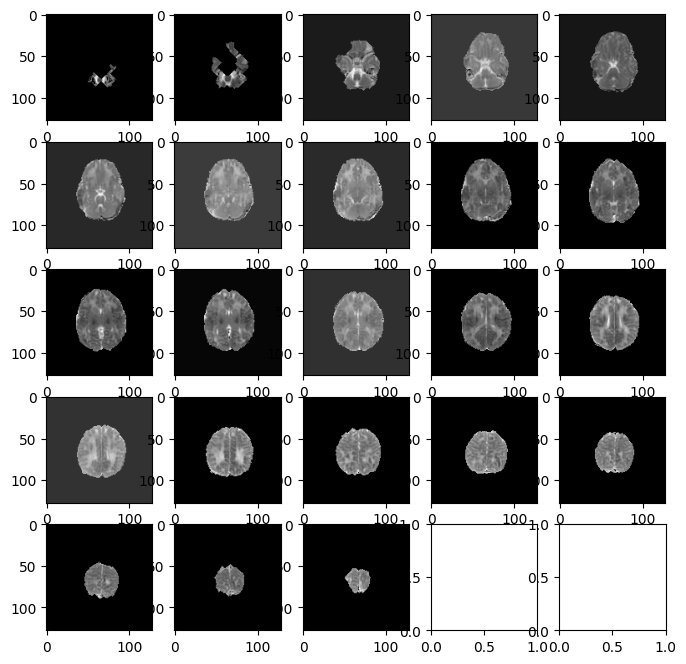

In [8]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < adc_data[0].shape[0]:
        ax.imshow(adc_data[0][i], cmap='gray')

Read and display Zadc data

In [9]:
zadc_data = []
for file in zadc_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    zadc_data.append(array)

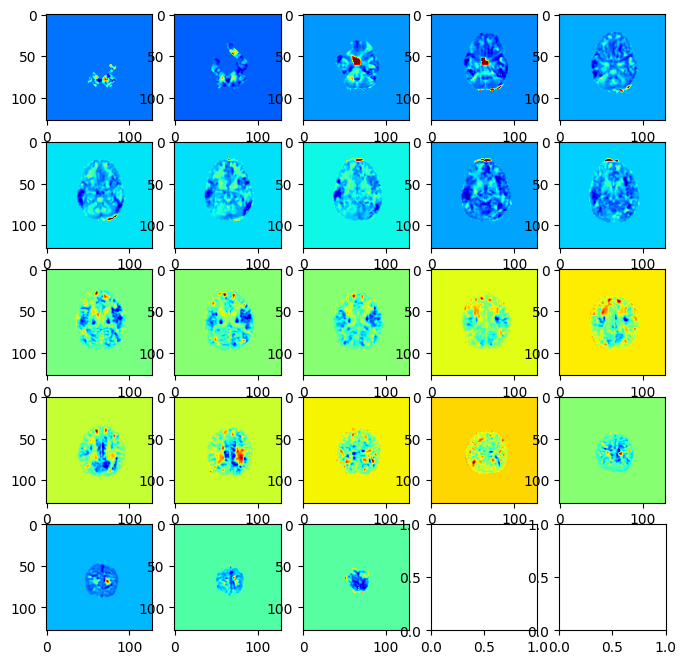

In [10]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < zadc_data[0].shape[0]:
        ax.imshow(zadc_data[0][i], cmap="jet")

Read and display label data

In [11]:
label_data = []
for file in label_files:
    image = sitk.ReadImage(file)
    array = sitk.GetArrayFromImage(image)
    label_data.append(array)

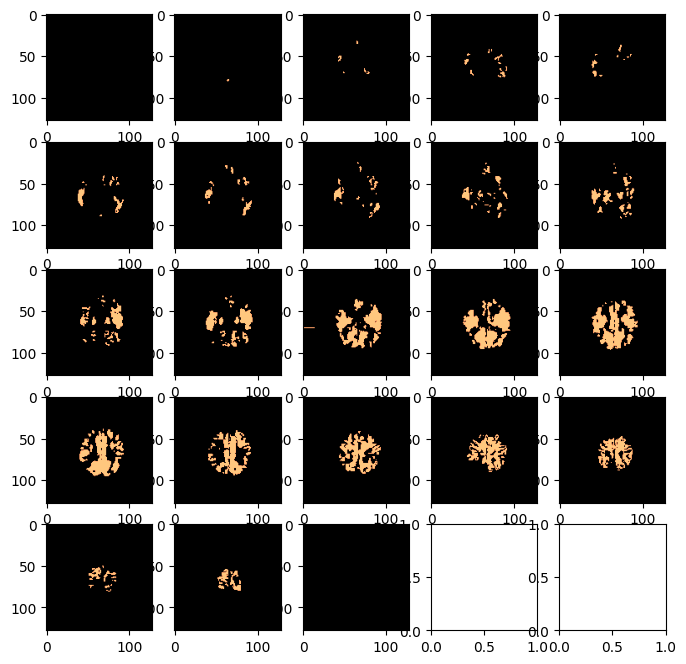

In [12]:
fig, axes = plt.subplots(5,5, figsize=(8,8))

for i,ax in enumerate(axes.flat):
    if i < label_data[0].shape[0]:
        ax.imshow(label_data[0][i], cmap="copper")

# **Ready data for training**

In [13]:
# Flatten a list of data with n length and (m, 128, 128) shape of each array, so it becomes a list of n*m of arrays of shape (128, 128)

flattened_adc_data = [item for sublist in adc_data for item in sublist]
flattened_zadc_data = [item for sublist in zadc_data for item in sublist]
flattened_label_data = [item for sublist in label_data for item in sublist]


In [14]:
def crop_center(image, crop_size=(128, 128)):
    height, width = image.shape
    new_height, new_width = crop_size

    start_x = width // 2 - new_width // 2
    start_y = height // 2 - new_height // 2

    return image[start_y:start_y + new_height, start_x:start_x + new_width]

In [15]:
flattened_cropped_zadc_data_list = [crop_center(image, crop_size=(128, 128)) for image in flattened_zadc_data]
flattened_cropped_label_data_list = [crop_center(image, crop_size=(128, 128)) for image in flattened_label_data]

In [16]:
# Convert the list of arrays to a single NumPy array
flattened_cropped_zadc_data = np.array(flattened_cropped_zadc_data_list)

# Reshape the array to have shape (num_samples, 128, 128, 1)
flattened_cropped_zadc_data = flattened_cropped_zadc_data.reshape((len(flattened_cropped_zadc_data_list), 128, 128, 1))

# Print the shape to verify
print(flattened_cropped_zadc_data.shape)

# If you also have label data in the same format

flattened_cropped_label_data = np.array(flattened_cropped_label_data_list)
flattened_cropped_label_data = flattened_cropped_label_data.reshape((len(flattened_cropped_label_data_list), 128, 128, 1))

# Print the shape to verify
print(flattened_cropped_label_data.shape)

(3206, 128, 128, 1)
(3206, 128, 128, 1)


# **FCN**

In [50]:
!pip install tensorflow

In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU

def fcn_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    merge1 = concatenate([u1, c3], axis=3)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge1)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    merge2 = concatenate([u2, c2], axis=3)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge2)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    merge3 = concatenate([u3, c1], axis=3)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge3)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

input_shape = (128, 128, 1)  # Assuming grayscale MRI images
model = fcn_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])

model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_103 (Conv2D) │ (None, 128, 128,  │        640 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_104 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_103[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 64, 64,    │          0 │ conv2d_104[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_105 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_23… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_106 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_105[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_24    │ (None, 32, 32,    │          0 │ conv2d_106[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_107 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_24… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_108 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_107[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_25    │ (None, 16, 16,    │          0 │ conv2d_108[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_109 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_25… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_110 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_109[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_6  │ (None, 32, 32,    │    524,544 │ conv2d_110[0][0]  │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_108[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_111 (Conv2D) │ (None, 32, 32,    │  1,179,904 │ concatenate_20[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_112 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_111[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_7  │ (None, 64, 64,    │    131,200 │ conv2d_112[0][0]

 Total params: 7,696,193 (29.36 MB)

 Trainable params: 7,696,193 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [53]:
# Define the input shape
input_shape = (128, 128, 1)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [54]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # checkpoint_filepath = '/content/drive/My Drive/Msc Project/FCN/model_checkpoint_{epoch:02d}.h5'
# checkpoint_filepath = '/FCN/model_checkpoint_{epoch:02d}.h5'

# model_checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=False,
#     monitor='val_mean_io_u',
#     mode='max',  # 'max' because you want to maximize the mean IoU
#     save_best_only=False,
#     save_freq='epoch',  # Save every epoch
#     period=5  # Save every 5th epoch
# )

In [55]:
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

# Define the custom callback
class CustomModelCheckpoint(Callback):
    def __init__(self, filepath, save_freq):
        super(CustomModelCheckpoint, self).__init__()
        self.filepath = filepath
        self.save_freq = save_freq

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            self.model.save(self.filepath.format(epoch=epoch + 1))

# Set the checkpoint file path
checkpoint_filepath = '/FCN/model_checkpoint_{epoch:02d}.h5'

# Initialize the custom callback
model_checkpoint_callback = CustomModelCheckpoint(
    filepath=checkpoint_filepath,
    save_freq=5  # Save every 5 epochs
)


In [56]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# best_model = tf.keras.models.load_model('/content/drive/My Drive/model_checkpoint.h5')

# Fit the model with validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback]) #, callbacks=[early_stopping])

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 551s 7s/step - accuracy: 0.9458 - loss: 0.2622 - mean_io_u_5: 0.4898 - val_accuracy: 0.9928 - val_loss: 0.0221 - val_mean_io_u_5: 0.4857
Epoch 2/50
72/81 ━━━━━━━━━━━━━━━━━━━━ 1:18 9s/step - accuracy: 0.9933 - loss: 0.0191 - mean_io_u_5: 0.4895

KeyboardInterrupt: 

# **Small encoder decoder 2**

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU
import keras

# def dice_coefficient(y_true, y_pred):
#     y_true_f = tf.keras.backend.flatten(y_true)
#     y_pred_f = tf.keras.backend.flatten(y_pred)
#     intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
#     return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

# Define the small encoder-decoder model
def small_encoder_decoder(input_shape):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2), padding='same')(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2), padding='same')(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2), padding='same')(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)

    # Decoder
    u5 = UpSampling2D((2, 2))(c4)
    c5 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = UpSampling2D((2, 2))(c5)
    c6 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    c7 = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(c7)

    model = Model(inputs=[inputs], outputs=[outputs])

    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=[MeanIoU(num_classes=2)])

    return model

In [ ]:
# Define the input shape
input_shape = (128, 128, 1)

# Create the model
model = small_encoder_decoder(input_shape)

# Print the model summary
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_95 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_96 (Conv2D)              │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_97 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_20 (UpSampling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 32, 32, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_21 (UpSampling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_22 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 128, 128, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 128, 128, 1)    │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,162,689 (4.44 MB)

 Trainable params: 1,162,689 (4.44 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_filepath = '/content/drive/My Drive/Msc Project/Simple Encoder Decoder model/model_checkpoint_{epoch:02d}.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mean_io_u',
    mode='max',  # 'max' because you want to maximize the mean IoU
    save_best_only=False,
    save_freq='epoch',  # Save every epoch
    period=5  # Save every 5th epoch
)

TypeError: ModelCheckpoint.__init__() got an unexpected keyword argument 'period'

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# best_model = tf.keras.models.load_model('/content/drive/My Drive/model_checkpoint.h5')

# Fit the model with validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback]) #, callbacks=[early_stopping])

Epoch 1/50
20/81 [======>.......................] - ETA: 10:21 - loss: 0.6683 - mean_io_u: 0.4889

In [ ]:
# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Get model predictions on a few samples
predictions = model.predict(X_val[:3])

# Visualize the predictions
def visualize_predictions(images, labels, predictions, num_samples=3):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(labels[i].reshape(128, 128), cmap='gray')
        plt.title('Label')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i].reshape(128, 128), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    plt.show()

visualize_predictions(X_val, y_val, predictions)


# **U Net**

In [18]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from keras.metrics import MeanIoU
from keras.optimizers import SGD
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def unet_model(input_size=(128, 128, 1), num_classes=1):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid' if num_classes == 1 else 'softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

# checkpoint_filepath = '/content/drive/My Drive/Msc Project/Simple Encoder Decoder model/model_checkpoint_{epoch:02d}.h5'
checkpoint_filepath = '/UNet/model_checkpoint_{epoch:02d}.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mean_io_u',
    mode='max',  # 'max' because you want to maximize the mean IoU
    save_best_only=False,
    save_freq='epoch',  # Save every epoch
    # period=5  # Save every 5th epoch
)

# CSVLogger to save all metrics
csv_logger = CSVLogger('training_log.csv', append=True)

In [22]:
# Compile the model
model = unet_model()
model.compile(optimizer=SGD(learning_rate=1e-4), loss=dice_loss, metrics=['accuracy', MeanIoU(num_classes=2)])

# Load the weights from the last checkpoint if they exist
latest_checkpoint = '/UNet/model_checkpoint_100.keras'
model.load_weights(latest_checkpoint)

# Summary of the model
model.summary()

OSError: Unable to synchronously open file (file signature not found)

In [23]:
# import tensorflow as tf
# # allow growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   try:
#     for gpu in gpus:
#       tf.config.experimental.set_memory_growth(gpu, True)
#   except RuntimeError as e:
#     print(e)

In [24]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# Fit the model with validation data
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback, csv_logger])


Epoch 1/200


ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/conv2d_35/Relu' defined at (most recent call last):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Windows\Temp\ipykernel_23992\215530763.py", line 5, in <module>
      history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback, csv_logger])
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_1/conv2d_35/Relu'
Detected at node 'model_1/conv2d_35/Relu' defined at (most recent call last):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Windows\Temp\ipykernel_23992\215530763.py", line 5, in <module>
      history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback, csv_logger])
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\reshm\miniconda3\envs\tf\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model_1/conv2d_35/Relu'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,192,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/conv2d_35/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[confusion_matrix/assert_less/Assert/AssertGuard/pivot_f/_21/_51]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[32,192,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/conv2d_35/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_5329]

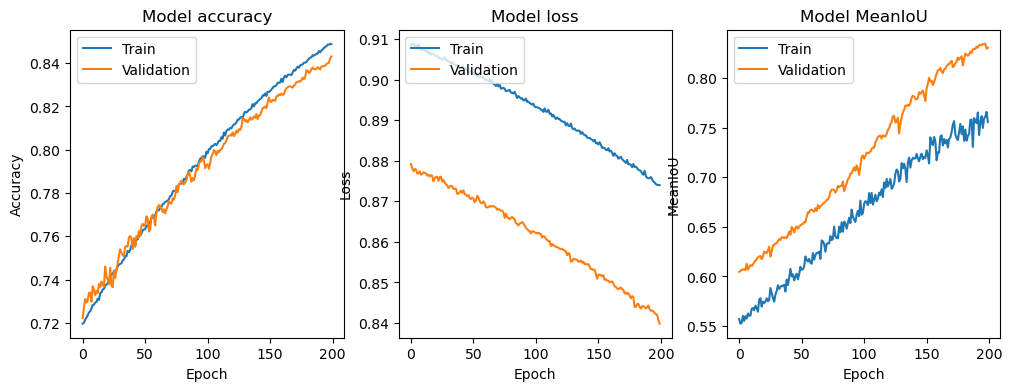

In [22]:
# Plot training & validation accuracy, loss, and MeanIoU values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['mean_io_u'])
plt.plot(history.history['val_mean_io_u'])
plt.title('Model MeanIoU')
plt.ylabel('MeanIoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


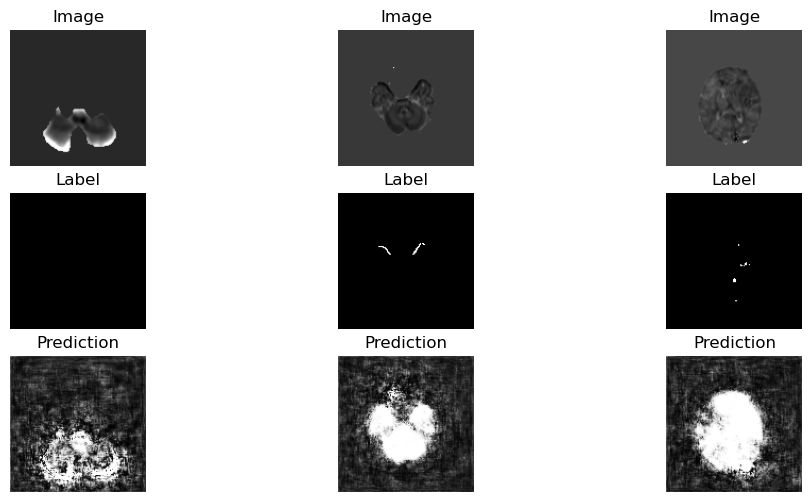

In [23]:
# Get model predictions on a few samples
predictions = model.predict(X_val[:3])

# Visualize the predictions
def visualize_predictions(images, labels, predictions, num_samples=3):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(labels[i].reshape(128, 128), cmap='gray')
        plt.title('Label')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i].reshape(128, 128), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    plt.show()

visualize_predictions(X_val, y_val, predictions)


# **U Net - adam and binary cross entropy**

In [20]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split

def unet_model(input_size=(128, 128, 1), num_classes=1):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # Decoder
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid' if num_classes == 1 else 'softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile the model
model = unet_model()
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])


# Summary of the model
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[

 Total params: 31,401,345 (119.79 MB)

 Trainable params: 31,389,569 (119.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

# checkpoint_filepath = '/content/drive/My Drive/Msc Project/Simple Encoder Decoder model/model_checkpoint_{epoch:02d}.h5'
checkpoint_filepath = '/UNet/model_checkpoint_{epoch:02d}.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_mean_io_u',
    mode='max',  # 'max' because you want to maximize the mean IoU
    save_best_only=False,
    save_freq='epoch',  # Save every epoch
    # period=5  # Save every 5th epoch
)

In [28]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(flattened_cropped_zadc_data, flattened_cropped_label_data, test_size=0.2, random_state=42)

# best_model = tf.keras.models.load_model('/content/drive/My Drive/model_checkpoint.h5')

# Fit the model with validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback]) #, callbacks=[early_stopping])

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1998s 24s/step - accuracy: 0.8829 - loss: 0.5501 - mean_io_u_1: 0.6254 - val_accuracy: 0.7305 - val_loss: 2.3208 - val_mean_io_u_1: 0.4710
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2041s 25s/step - accuracy: 0.9895 - loss: 0.1889 - mean_io_u_1: 0.7061 - val_accuracy: 0.9736 - val_loss: 0.1026 - val_mean_io_u_1: 0.4857
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2387s 30s/step - accuracy: 0.9879 - loss: 0.1153 - mean_io_u_1: 0.6711 - val_accuracy: 0.9766 - val_loss: 0.0787 - val_mean_io_u_1: 0.4857
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2023s 25s/step - accuracy: 0.9881 - loss: 0.0677 - mean_io_u_1: 0.6114 - val_accuracy: 0.9904 - val_loss: 0.0609 - val_mean_io_u_1: 0.4893
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9912 - loss: 0.0436 - mean_io_u_1: 0.5757 

81/81 ━━━━━━━━━━━━━━━━━━━━ 1980s 24s/step - accuracy: 0.9912 - loss: 0.0436 - mean_io_u_1: 0.5757 - val_accuracy: 0.9753 - val_loss: 0.0765 - val_mean_io_u_1: 0.4857
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1984s 24s/step - accuracy: 0.9932 - loss: 0.0313 - mean_io_u_1: 0.5857 - val_accuracy: 0.9806 - val_loss: 0.0523 - val_mean_io_u_1: 0.4857
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2014s 25s/step - accuracy: 0.9938 - loss: 0.0258 - mean_io_u_1: 0.5791 - val_accuracy: 0.9843 - val_loss: 0.0423 - val_mean_io_u_1: 0.4868
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1954s 24s/step - accuracy: 0.9937 - loss: 0.0247 - mean_io_u_1: 0.5765 - val_accuracy: 0.9870 - val_loss: 0.0378 - val_mean_io_u_1: 0.4947
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1856s 23s/step - accuracy: 0.9939 - loss: 0.0222 - mean_io_u_1: 0.5559 - val_accuracy: 0.9913 - val_loss: 0.0265 - val_mean_io_u_1: 0.5279
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.9937 - loss: 0.0223 - mean_io_u_1: 0.5705 

81/81 ━━━━━━━━━━━━━━━━━━━━ 1788s 22s/step - accuracy: 0.9937 - loss: 0.0223 - mean_io_u_1: 0.5706 - val_accuracy: 0.9932 - val_loss: 0.0233 - val_mean_io_u_1: 0.6181
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1873s 23s/step - accuracy: 0.9947 - loss: 0.0177 - mean_io_u_1: 0.5694 - val_accuracy: 0.9932 - val_loss: 0.0217 - val_mean_io_u_1: 0.5946
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 2313s 29s/step - accuracy: 0.9938 - loss: 0.0199 - mean_io_u_1: 0.5711 - val_accuracy: 0.9914 - val_loss: 0.0254 - val_mean_io_u_1: 0.6303
Epoch 13/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1888s 23s/step - accuracy: 0.9938 - loss: 0.0192 - mean_io_u_1: 0.5683 - val_accuracy: 0.9934 - val_loss: 0.0212 - val_mean_io_u_1: 0.5772
Epoch 14/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1005s 12s/step - accuracy: 0.9948 - loss: 0.0167 - mean_io_u_1: 0.5646 - val_accuracy: 0.9935 - val_loss: 0.0202 - val_mean_io_u_1: 0.5982
Epoch 15/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9936 - loss: 0.0187 - mean_io_u_1: 0.5635

81/81 ━━━━━━━━━━━━━━━━━━━━ 753s 9s/step - accuracy: 0.9936 - loss: 0.0187 - mean_io_u_1: 0.5635 - val_accuracy: 0.9934 - val_loss: 0.0213 - val_mean_io_u_1: 0.6212
Epoch 16/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 623s 8s/step - accuracy: 0.9940 - loss: 0.0179 - mean_io_u_1: 0.5671 - val_accuracy: 0.9935 - val_loss: 0.0226 - val_mean_io_u_1: 0.6126
Epoch 17/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 842s 10s/step - accuracy: 0.9940 - loss: 0.0176 - mean_io_u_1: 0.5618 - val_accuracy: 0.9935 - val_loss: 0.0206 - val_mean_io_u_1: 0.5718
Epoch 18/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 651s 8s/step - accuracy: 0.9942 - loss: 0.0173 - mean_io_u_1: 0.5698 - val_accuracy: 0.9912 - val_loss: 0.0244 - val_mean_io_u_1: 0.5721
Epoch 19/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 651s 8s/step - accuracy: 0.9946 - loss: 0.0154 - mean_io_u_1: 0.5564 - val_accuracy: 0.9930 - val_loss: 0.0209 - val_mean_io_u_1: 0.5545
Epoch 20/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9948 - loss: 0.0155 - mean_io_u_1: 0.5455

81/81 ━━━━━━━━━━━━━━━━━━━━ 649s 8s/step - accuracy: 0.9948 - loss: 0.0155 - mean_io_u_1: 0.5456 - val_accuracy: 0.9921 - val_loss: 0.0211 - val_mean_io_u_1: 0.5495
Epoch 21/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 661s 8s/step - accuracy: 0.9942 - loss: 0.0165 - mean_io_u_1: 0.5623 - val_accuracy: 0.9937 - val_loss: 0.0213 - val_mean_io_u_1: 0.5649
Epoch 22/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 663s 8s/step - accuracy: 0.9950 - loss: 0.0153 - mean_io_u_1: 0.5477 - val_accuracy: 0.9935 - val_loss: 0.0194 - val_mean_io_u_1: 0.5934
Epoch 23/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 697s 9s/step - accuracy: 0.9920 - loss: 0.0208 - mean_io_u_1: 0.5357 - val_accuracy: 0.9933 - val_loss: 0.0202 - val_mean_io_u_1: 0.5893
Epoch 24/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 751s 9s/step - accuracy: 0.9946 - loss: 0.0158 - mean_io_u_1: 0.5531 - val_accuracy: 0.9919 - val_loss: 0.0228 - val_mean_io_u_1: 0.5667
Epoch 25/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9938 - loss: 0.0172 - mean_io_u_1: 0.5446

81/81 ━━━━━━━━━━━━━━━━━━━━ 792s 10s/step - accuracy: 0.9938 - loss: 0.0172 - mean_io_u_1: 0.5447 - val_accuracy: 0.9935 - val_loss: 0.0184 - val_mean_io_u_1: 0.5863
Epoch 26/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 709s 9s/step - accuracy: 0.9944 - loss: 0.0155 - mean_io_u_1: 0.5366 - val_accuracy: 0.9930 - val_loss: 0.0241 - val_mean_io_u_1: 0.5832
Epoch 27/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 695s 9s/step - accuracy: 0.9947 - loss: 0.0143 - mean_io_u_1: 0.5458 - val_accuracy: 0.9935 - val_loss: 0.0180 - val_mean_io_u_1: 0.5886
Epoch 28/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 840s 9s/step - accuracy: 0.9949 - loss: 0.0140 - mean_io_u_1: 0.5509 - val_accuracy: 0.9924 - val_loss: 0.0195 - val_mean_io_u_1: 0.6051
Epoch 29/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 734s 9s/step - accuracy: 0.9944 - loss: 0.0153 - mean_io_u_1: 0.5493 - val_accuracy: 0.9932 - val_loss: 0.0189 - val_mean_io_u_1: 0.6244
Epoch 30/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.9947 - loss: 0.0148 - mean_io_u_1: 0.5526 

81/81 ━━━━━━━━━━━━━━━━━━━━ 929s 11s/step - accuracy: 0.9947 - loss: 0.0148 - mean_io_u_1: 0.5526 - val_accuracy: 0.9933 - val_loss: 0.0180 - val_mean_io_u_1: 0.5749
Epoch 31/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 974s 12s/step - accuracy: 0.9950 - loss: 0.0138 - mean_io_u_1: 0.5463 - val_accuracy: 0.9915 - val_loss: 0.0260 - val_mean_io_u_1: 0.5350
Epoch 32/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1259s 16s/step - accuracy: 0.9945 - loss: 0.0142 - mean_io_u_1: 0.5319 - val_accuracy: 0.9936 - val_loss: 0.0182 - val_mean_io_u_1: 0.5751
Epoch 33/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 1898s 23s/step - accuracy: 0.9953 - loss: 0.0125 - mean_io_u_1: 0.5413 - val_accuracy: 0.9933 - val_loss: 0.0200 - val_mean_io_u_1: 0.5182
Epoch 34/50


In [ ]:
# Plot training & validation accuracy and loss values
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Get model predictions on a few samples
predictions = model.predict(X_val[:3])

# Visualize the predictions
def visualize_predictions(images, labels, predictions, num_samples=3):
    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')
        plt.title('Image')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(labels[i].reshape(128, 128), cmap='gray')
        plt.title('Label')
        plt.axis('off')

        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i].reshape(128, 128), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    plt.show()

visualize_predictions(X_val, y_val, predictions)


# **K-Fold**

In [ ]:
from sklearn.model_selection import KFold

X = flattened_cropped_zadc_data
y = flattened_cropped_label_data

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    historyK = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback])